In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller
from nltk.corpus import stopwords


from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold,StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, classification_report, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics.pairwise import pairwise_distances
import joblib

## Data loading 

In [2]:
rating_original = pd.read_csv('sample30.csv')

In [3]:
rating= rating_original.copy()

## Data Cleaning 

In [4]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [5]:
rating.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [6]:
percent_missing = rating.isnull().sum() * 100 / len(rating)
percent_missing

id                       0.000000
brand                    0.000000
categories               0.000000
manufacturer             0.470000
name                     0.000000
reviews_date             0.153333
reviews_didPurchase     46.893333
reviews_doRecommend      8.566667
reviews_rating           0.000000
reviews_text             0.000000
reviews_title            0.633333
reviews_userCity        93.570000
reviews_userProvince    99.433333
reviews_username         0.210000
user_sentiment           0.003333
dtype: float64

reviews_userCity and reviews_userProvince have null values 93.5% and 99.4%. Imputation would npt help here. it is okay to remove these two variables because these two variable doesnot impact the sentiment analaysis and recommendation system also.

In [7]:
rating = rating.drop(['reviews_userCity', 'reviews_userProvince'], axis=1)

In [8]:
#null values % check
percent_missing = rating.isnull().sum() * 100 / len(rating)
percent_missing

id                      0.000000
brand                   0.000000
categories              0.000000
manufacturer            0.470000
name                    0.000000
reviews_date            0.153333
reviews_didPurchase    46.893333
reviews_doRecommend     8.566667
reviews_rating          0.000000
reviews_text            0.000000
reviews_title           0.633333
reviews_username        0.210000
user_sentiment          0.003333
dtype: float64

In [9]:
rating = rating.drop(['reviews_didPurchase'], axis=1)

In [10]:
# null values % check
percent_missing = rating.isnull().sum() * 100 / len(rating)
percent_missing

id                     0.000000
brand                  0.000000
categories             0.000000
manufacturer           0.470000
name                   0.000000
reviews_date           0.153333
reviews_doRecommend    8.566667
reviews_rating         0.000000
reviews_text           0.000000
reviews_title          0.633333
reviews_username       0.210000
user_sentiment         0.003333
dtype: float64

in user_sentiment one row has null value. checking that 

In [11]:
rating[rating['user_sentiment'].isnull()]['reviews_text']

28354    my kids absolutely loved this film so much tha...
Name: reviews_text, dtype: object

this review seems to be positive and mentioned that he liked the product. So, updating this row as positive review

In [12]:
rating.loc[rating['user_sentiment'].isnull(),'user_sentiment'] = 'Positive'

In [13]:
#null values % checking 
rating.isnull().sum(axis=0)

id                        0
brand                     0
categories                0
manufacturer            141
name                      0
reviews_date             46
reviews_doRecommend    2570
reviews_rating            0
reviews_text              0
reviews_title           190
reviews_username         63
user_sentiment            0
dtype: int64

removing review_date also as it is also not importnat for sentiment analysis

In [14]:
#remove the review_data column
rating = rating.drop(['reviews_date'], axis=1)

In [15]:
#null values % checking 
rating.isnull().sum(axis=0)

id                        0
brand                     0
categories                0
manufacturer            141
name                      0
reviews_doRecommend    2570
reviews_rating            0
reviews_text              0
reviews_title           190
reviews_username         63
user_sentiment            0
dtype: int64

checking manufacturer column and brand

In [16]:
rating[rating['manufacturer'].isnull()]['brand'].value_counts()

Summit Entertainment    141
Name: brand, dtype: int64

since all the null values have same brand, let us check the manufacture of "Summit Entertainment"

In [17]:
rating[rating['brand'] == 'Summit Entertainment']['manufacturer'].value_counts()

Summit Entertainment    672
Name: manufacturer, dtype: int64

for brand "Summit Entertainment", manufacture is also "Summit Entertainment". It is okay to assign the "Summit Entertainment" in manufacture column. Because one manufacture can have multiple brand but one brand can not belong to multiple manufactures. so, assigning the "Summit Entertainment" to manufacturer column.

In [18]:
rating.loc[rating['manufacturer'].isnull(), 'manufacturer'] = 'Summit Entertainment'

In [19]:
#again checking null values
rating.isnull().sum(axis=0)

id                        0
brand                     0
categories                0
manufacturer              0
name                      0
reviews_doRecommend    2570
reviews_rating            0
reviews_text              0
reviews_title           190
reviews_username         63
user_sentiment            0
dtype: int64

removing the username missing rows because as we will make recommendation based on username, we can not impute random names here. Similarily, we can not impute the title also, so it is safe to remove the row where title and username are missing. 

In [20]:
rating = rating[~rating['reviews_username'].isnull()]
rating = rating[~rating['reviews_title'].isnull()]

In [21]:
#again checking null values
rating.isnull().sum(axis=0)

id                        0
brand                     0
categories                0
manufacturer              0
name                      0
reviews_doRecommend    2376
reviews_rating            0
reviews_text              0
reviews_title             0
reviews_username          0
user_sentiment            0
dtype: int64

removing "reviews_doRecommend" as review_text and review_rating has similar information. 

In [22]:
rating = rating.drop(['reviews_doRecommend'], axis=1)

In [23]:
#again checking null values
rating.isnull().sum(axis=0)

id                  0
brand               0
categories          0
manufacturer        0
name                0
reviews_rating      0
reviews_text        0
reviews_title       0
reviews_username    0
user_sentiment      0
dtype: int64

check for duplicate coolumns

In [24]:
rating[rating.duplicated()].shape

(279, 10)

279 rows are duplicate, remove these rows.

In [25]:
rating = rating[~(rating.duplicated())]

checking dataset after data cleaning

In [26]:
rating.shape

(29469, 10)

In [27]:
#data loss in data cleaning step is :
data_loss = ((rating_original.shape[0]-rating.shape[0])/rating_original.shape[0])*100
data_loss

1.77

1.77% data loss in cleaning step 

## data cleaning: data type checking

In [28]:
rating.dtypes

id                  object
brand               object
categories          object
manufacturer        object
name                object
reviews_rating       int64
reviews_text        object
reviews_title       object
reviews_username    object
user_sentiment      object
dtype: object

checking brand names and check spelling also

In [29]:
rating['brand'].unique()

array(['Universal Music', 'Lundberg', 'K-Y', 'J.R. Watkins', 'AMBI',
       "Johnson's", 'Olay', 'Windex', 'Heinz', 'KIND', 'Pantene',
       'Aussie', 'Disney', 'CeraVe', 'Solo Foods', 'Finish',
       'Jake And The Neverland Pirates', 'Pearhead', 'No Brand',
       'Neutrogena', 'Meguiars', 'Banana Boat', 'Cetaphil', 'Suave',
       'Bumble Bee', 'Citrus Magic', 'La Tortilla Factory',
       'Target.com Use Only', 'Sea Gull Lighting', 'The Seaweed Bath Co.',
       'Way Basics', 'Biokleen', 'Yes to Carrots', 'Alberto VO5',
       'Warner Bros.', 'FOX', 'Progresso', "Herr's", 'Hawaiian Punch',
       'Universal Home Video', 'Holmes', 'Sony Music', "Nature's Path",
       'Lite Source', 'SLOAN VALVE COMPANY', 'Nearly Natural',
       'Toy Story', 'MaraNatha', 'Chex', 'TRESemme', 'Wagan',
       'Creme Of Nature', 'Arrid', 'Eagle Brand', 'Pinaud',
       'Hortense B. Hewitt', 'Canada Dry', 'Baxter of California', 'Ragu',
       'Sabra', 'Pendaflex', "Newman's Own Organics",
       'The 

checking manufacture name

In [30]:
rating['manufacturer'].unique()

array(['Universal Music Group / Cash Money', 'Lundberg', 'K-Y',
       'J.R. Watkins', 'FLEMING & CO', "Johnson's", 'P&G', 'Windex',
       'Heinz North America', 'Kind Fruit & Nut Bars', 'Pantene',
       'Aussie', 'Disney/Pixar', 'CeraVe', 'Solo', 'Reckitt Benckiser',
       'Disney', 'Pearhead', '120', 'Johnson & Johnson SLC', 'Parts',
       'Energizer Personal Care', 'Cetaphil', 'UNILEVER', 'Bumble Bee',
       'Citrus Magic', 'La Tortilla Fac', 'Xenon', 'Sea Gull Lighting',
       'The Seaweed Bath', 'Way Basics', 'Biokleen Cleaners',
       'Yes To Inc.', 'High Ridge Brands Co.', 'TIME WARNER',
       'MGM (Video & DVD)', 'Twentieth Century Fox',
       'GENERAL MILLS SALES, INC.', "Herr's", 'Dr Pepper/Seven Up, Inc',
       'Universal', 'UNIVERSAL HOME ENTERTAINMENT',
       'Jarden Home Environment', 'Columbia', 'Pantene Pro-V Hair Care',
       "Nature's Path Foods, Inc.", 'Lite-Source', 'William H Harvey',
       'Nearly Natural', 'Disguise', 'Maranatha Natural Foods',
     

In [31]:
rating['name'].unique()

array(['Pink Friday: Roman Reloaded Re-Up (w/dvd)',
       'Lundberg Organic Cinnamon Toast Rice Cakes',
       'K-Y Love Sensuality Pleasure Gel',
       'J.R. Watkins Hand Cream, Lemon Cream',
       'Ambi Complexion Cleansing Bar',
       "Johnson's Baby Bubble Bath and Wash, 15oz",
       'Olay Regenerist Deep Hydration Regenerating Cream',
       'Windex Original Glass Cleaner Refill 67.6oz (2 Liter)',
       'Heinz Tomato Ketchup, 38oz',
       'Kind Dark Chocolate Chunk Gluten Free Granola Bars - 5 Count',
       'Pantene Color Preserve Volume Shampoo, 25.4oz',
       'Aussie Aussome Volume Shampoo, 13.5 Oz',
       "Cars Toon: Mater's Tall Tales", 'CeraVe SA Renewing Cream',
       'Solo Foods Almond Paste',
       'Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count',
       'Disney174 Jake And The Neverland Pirates 4 Piece Bedding Set - Toddler',
       'Pearhead Id Bracelet Frame',
       'Craft Punch Giga Scallop Circle 45 24687534 To 334',
       'Neutrogena

There are few mistake in L'oreal shampoo name, lets correct that

In [32]:
def product_name(str1):
    pat = "^L'or[0-9]+al"
    if(re.search(pat, str1)):
        return str1
    else:
        return False
rating.loc[rating['name'] == rating['name'].apply(lambda x:product_name(x)),'name'] = rating.loc[rating['name'] == rating['name'].apply(lambda x:product_name(x)),'name'].str.replace('^L\'or[0-9]+al', 'L\'oreal') 

C:\Users\0296A6~1\AppData\Local\Temp/ipykernel_47080/81001066.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  rating.loc[rating['name'] == rating['name'].apply(lambda x:product_name(x)),'name'] = rating.loc[rating['name'] == rating['name'].apply(lambda x:product_name(x)),'name'].str.replace('^L\'or[0-9]+al', 'L\'oreal')


In [33]:
#recheck name
rating[rating['name'] == rating['name'].apply(lambda x:product_name(x))]['name']

Series([], Name: name, dtype: object)

In [34]:
rating = rating.reset_index(drop=True)
rating.index

RangeIndex(start=0, stop=29469, step=1)

#data cleaning step completed 

## EDA

In [35]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29469 entries, 0 to 29468
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                29469 non-null  object
 1   brand             29469 non-null  object
 2   categories        29469 non-null  object
 3   manufacturer      29469 non-null  object
 4   name              29469 non-null  object
 5   reviews_rating    29469 non-null  int64 
 6   reviews_text      29469 non-null  object
 7   reviews_title     29469 non-null  object
 8   reviews_username  29469 non-null  object
 9   user_sentiment    29469 non-null  object
dtypes: int64(1), object(9)
memory usage: 2.2+ MB


Stats for column : id
AVpf3VOfilAPnD_xjpun    8396
AVpfPaoqLJeJML435Xk9    3324
AVpfJP1C1cnluZ0-e3Xy    2022
AVpfRTh1ilAPnD_xYic2    1140
AVpfW8y_LJeJML437ySW    1118
                        ... 
AV1YIch7GV-KLJ3addeG       1
AVpfpoUCLJeJML43BLXv       1
AV1YpiJvvKc47QAVguxy       1
AVpfP-rELJeJML435jEN       1
AV13O1A8GV-KLJ3akUyj       1
Name: id, Length: 252, dtype: int64


Stats for column : brand
Clorox                   10419
Warner Home Video         3324
Disney                    1197
L'oreal Paris             1118
FOX                        887
                         ...  
JNH Lifestyles               1
Teamson                      1
Rizzy Home                   1
Pacific Natural Foods        1
Mill Creek                   1
Name: brand, Length: 199, dtype: int64


Stats for column : categories
Household Essentials,Cleaning Supplies,Kitchen Cleaners,Cleaning Wipes,All-Purpose Cleaners,Health & Household,Household Supplies,Household Cleaning,Ways To Shop,Classroom Essentials,F



Stats for column : reviews_title
Great Product                    369
Great movie                      361
Clorox Wipes                     269
Great                            216
Great product                    205
                                ... 
Smells great - cleans too          1
absolutely love these wipes        1
maggie                             1
Powerful cleanng + good value      1
Conditioned into healthy           1
Name: reviews_title, Length: 18490, dtype: int64


Stats for column : reviews_username
byamazon customer    41
mike                 41
chris                31
rick                 15
sandy                15
                     ..
teece                 1
george2211            1
teambowser            1
eve324                1
kcoopxoxo             1
Name: reviews_username, Length: 24788, dtype: int64


Stats for column : user_sentiment
Positive    26163
Negative     3306
Name: user_sentiment, dtype: int64




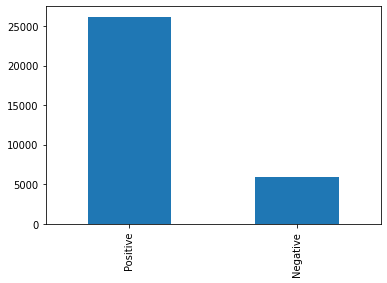

In [36]:
def plot_data(col):
    print(rating[col].value_counts())
    rating[col].value_counts().plot(kind='bar') 
for col in rating.columns:
    print("Stats for column : "+col )
    plot_data(col)
    print("\n")

<AxesSubplot:xlabel='user_sentiment', ylabel='count'>

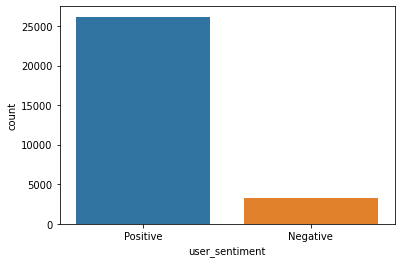

In [37]:
sns.countplot(x='user_sentiment', data= rating)

<AxesSubplot:xlabel='reviews_rating', ylabel='count'>

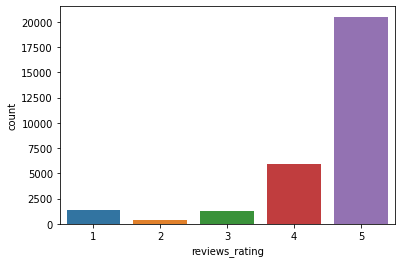

In [38]:
sns.countplot(x='reviews_rating', data= rating)

<AxesSubplot:xlabel='brand'>

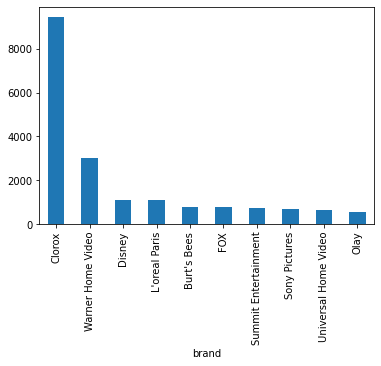

In [39]:
#top 10 brands with positive rating
rating[rating['user_sentiment']=='Positive'].groupby('brand')['brand'].count().sort_values(ascending=False)[:10].plot(kind='bar')

<AxesSubplot:xlabel='brand'>

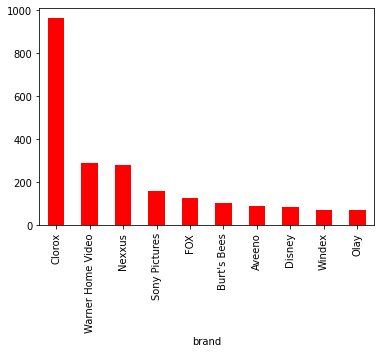

In [40]:
#top 10 brands with negative rating
rating[rating['user_sentiment']=='Negative'].groupby('brand')['brand'].count().sort_values(ascending=False)[:10].plot(kind='bar',color='r')

<AxesSubplot:>

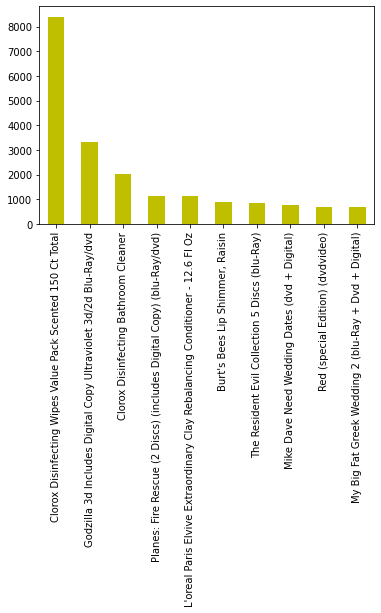

In [41]:
#top 10 products 
rating['name'].value_counts().sort_values(ascending=False)[:10].plot(kind='bar',color='y')


In [42]:
#the top most reviewed products, manufacturers and brands
top_10_product = rating['name'].value_counts().sort_values(ascending=False)[:10]
top_10_product

Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                       8396
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                 3324
Clorox Disinfecting Bathroom Cleaner                                            2022
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)             1140
L'oreal Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz    1118
Burt's Bees Lip Shimmer, Raisin                                                  873
The Resident Evil Collection 5 Discs (blu-Ray)                                   845
Mike Dave Need Wedding Dates (dvd + Digital)                                     757
Red (special Edition) (dvdvideo)                                                 672
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)                             668
Name: name, dtype: int64

In [43]:
top_product_df = rating[rating['name'].isin(top_10_product.index.tolist())]
top_product_df.head(2)

,id,brand,categories,manufacturer,name,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
1773,AVpe41TqilAPnD_xQH3d,FOX,"Movies & TV Shows,Movies,Romance,Romantic Come...",Twentieth Century Fox,Mike Dave Need Wedding Dates (dvd + Digital),1,I expected more from this movie and more from ...,Not as funny as I thought,elite,Positive
1774,AVpe41TqilAPnD_xQH3d,FOX,"Movies & TV Shows,Movies,Romance,Romantic Come...",Twentieth Century Fox,Mike Dave Need Wedding Dates (dvd + Digital),1,Would ABSOLUTELY NOT recommend. We could only ...,Mike & Dave Need Wedding Dates,tampa,Negative


<AxesSubplot:xlabel='reviews_rating', ylabel='name'>

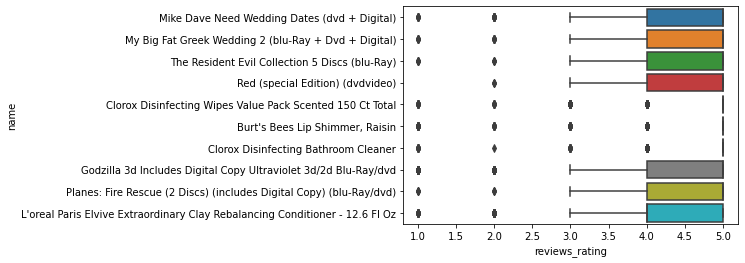

In [44]:
sns.boxplot(x='reviews_rating',y='name',data=top_product_df)

All products are having rating from 4 to 5 and they are good products

<AxesSubplot:xlabel='reviews_rating', ylabel='manufacturer'>

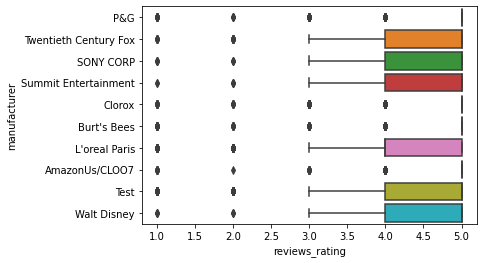

In [45]:
top_10_manufacturer= rating['manufacturer'].value_counts().sort_values(ascending=False)[:10]
top_manufacturer_df = rating[rating['manufacturer'].isin(top_10_manufacturer.index.tolist())]
sns.boxplot(x='reviews_rating',y='manufacturer',data=top_manufacturer_df)

<AxesSubplot:xlabel='reviews_rating', ylabel='brand'>

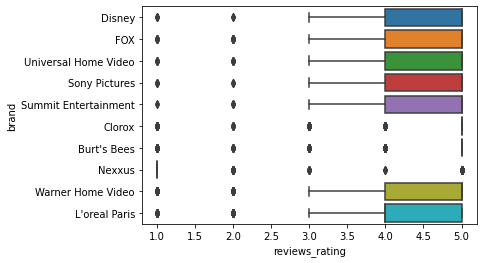

In [46]:
top_10_brand= rating['brand'].value_counts().sort_values(ascending=False)[:10]
top_brand_df = rating[rating['brand'].isin(top_10_brand.index.tolist())]
sns.boxplot(x='reviews_rating',y='brand',data=top_brand_df)

all top brand and manufacturer are having rating from 4 to 5.

In [47]:
#unique product:
len(rating['name'].unique())


252

In [48]:
#unique user
len(rating['reviews_username'].unique())

24788

## Recommendation System

There are two approaches 
1) item -item based recommendation

2) user - user based recommendation


###  Item Item based Recommendation 

In [49]:
rating_df=rating[['name', 'reviews_username', 'reviews_rating']]
rating_df

,name,reviews_username,reviews_rating
0,Pink Friday: Roman Reloaded Re-Up (w/dvd),joshua,5
1,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
2,Lundberg Organic Cinnamon Toast Rice Cakes,dorothy w,5
3,K-Y Love Sensuality Pleasure Gel,rebecca,1
4,K-Y Love Sensuality Pleasure Gel,walker557,1
...,...,...,...
29464,L'oreal Paris Elvive Extraordinary Clay Rebala...,laurasnchz,5
29465,L'oreal Paris Elvive Extraordinary Clay Rebala...,scarlepadilla,5
29466,L'oreal Paris Elvive Extraordinary Clay Rebala...,liviasuexo,5
29467,L'oreal Paris Elvive Extraordinary Clay Rebala...,ktreed95,5


In [50]:
# Test and Train split of the dataset.
train, test = train_test_split(rating_df, test_size=0.30, random_state=10)

In [51]:
print(train.shape)
print(test.shape)

(20628, 3)
(8841, 3)


In [52]:
rating_pivot = train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).T
rating_pivot.head()

reviews_username,00dog3,00sab00,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,...,zozo0o,zpalma,zsarah,zt313,zubb,zulaa118,zuttle,zxcsdfd,zxjki,zzdiane
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
# Item Similarity Matrix
item_corr = 1 - pairwise_distances(rating_pivot.fillna(0), metric='cosine')
item_corr[np.isnan(item_corr)] = 0
#extracting positive correlations
item_corr[item_corr < 0]=0 
item_corr

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.00169362, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.00169362, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

 ###  Item - item :
 Compute dot product of user item rating 

In [54]:
item_ratings = np.dot((rating_pivot.fillna(0).T),item_corr)
item_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.0227966 , 0.        , ..., 0.07315108, 0.        ,
        0.00237758],
       [0.        , 0.07187147, 0.        , ..., 0.05767533, 0.        ,
        0.01820386],
       ...,
       [0.        , 0.01796559, 0.        , ..., 0.03339443, 0.01072933,
        0.        ],
       [0.        , 0.00718624, 0.        , ..., 0.01335777, 0.00429173,
        0.        ],
       [0.        , 0.01815624, 0.        , ..., 0.08532461, 0.        ,
        0.        ]])

In [55]:
train_dummy = (rating_pivot.fillna(0)==0).astype(int)
train_dummy = train_dummy.T
train_dummy.shape

(18067, 235)

In [56]:
item_based_final_rating = np.multiply(item_ratings,train_dummy)
item_based_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",...,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Wallmount Server Cabinet (450mm, 9 RU)","Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Wedding Wishes Wedding Guest Book,Weleda Everon Lip Balm,Wilton Black Dots Standard Baking Cups,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
00sab00,0.0,0.022797,0.0,0.0,0.0,0.0,0.0,0.0,0.042593,0.000000,...,0.147929,0.0,0.0,0.046607,0.0,0.0,0.0,0.073151,0.000000,0.002378
02deuce,0.0,0.071871,0.0,0.0,0.0,0.0,0.0,0.0,0.044473,0.000000,...,0.090002,0.0,0.0,0.044898,0.0,0.0,0.0,0.057675,0.000000,0.018204
0325home,0.0,0.017966,0.0,0.0,0.0,0.0,0.0,0.0,0.013121,0.030859,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.033394,0.010729,0.000000
06stidriver,0.0,0.017966,0.0,0.0,0.0,0.0,0.0,0.0,0.013121,0.030859,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.033394,0.010729,0.000000


Find the top 20 Recommendation 

In [57]:
input_username="00sab00"

In [58]:
# Recommend the Top 20 products 
item_recommendations = item_based_final_rating.loc[input_username].sort_values(ascending=False)[0:20]
item_recommendations

name
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)                0.149229
Wagan Smartac 80watt Inverter With Usb                                             0.147929
Various - Red Hot Blue:Tribute To Cole Porter (cd)                                 0.132106
SC Johnson One Step No Buff Wax                                                    0.121780
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                    0.112185
The Resident Evil Collection 5 Discs (blu-Ray)                                     0.102759
Tostitos Bite Size Tortilla Chips                                                  0.101640
Meguiar's Deep Crystal Car Wash 64-Oz.                                             0.094296
Equals (blu-Ray)                                                                   0.089929
Lysol Concentrate Deodorizing Cleaner, Original Scent                              0.080239
Chester's Cheese Flavored Puffcorn Snacks                                  

In [59]:
#save this model for deployement 
joblib.dump(item_based_final_rating, 'model/item_based_final_rating') 

['model/item_based_final_rating']

In [60]:
test.columns

common =  test[test.name.isin(train.name)]
print(common.shape)
common.head(4)

(8824, 3)


,name,reviews_username,reviews_rating
17807,There's Something About Mary (dvd),a11mxdup,4
19337,Clorox Disinfecting Bathroom Cleaner,petals66,5
1369,"Cetaphil Gentle Skin Cleanser, 2oz",danny,5
16180,"Burt's Bees Lip Shimmer, Raisin",ducky,5


In [61]:
common_item_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T
common_item_matrix.shape

(179, 8255)

In [62]:
df_item_correlation= pd.DataFrame(item_corr)

In [63]:
df_item_correlation.head()

,0,1,2,3,4,5,6,7,8,9,...,225,226,227,228,229,230,231,232,233,234
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001694,0.000000,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.155493,0.0


In [64]:
rating_pivot.index

Index(['0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest',
       '100:Complete First Season (blu-Ray)',
       '2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black',
       '2x Ultra Era with Oxi Booster, 50fl oz',
       '42 Dual Drop Leaf Table with 2 Madrid Chairs"',
       '4C Grated Parmesan Cheese 100% Natural 8oz Shaker',
       'Africa's Best No-Lye Dual Conditioning Relaxer System Super',
       'Alberto VO5 Salon Series Smooth Plus Sleek Shampoo',
       'Alex Cross (dvdvideo)', 'All,bran Complete Wheat Flakes, 18 Oz.',
       ...
       'Wagan Smartac 80watt Inverter With Usb',
       'Walkers Stem Ginger Shortbread',
       'Wallmount Server Cabinet (450mm, 9 RU)',
       'Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee',
       'Wedding Wishes Wedding Guest Book', 'Weleda Everon Lip Balm',
       'Wilton Black Dots Standard Baking Cups',
       'Windex Original Glass Cleaner Refill 67.6oz (

In [65]:
df_item_correlation['name'] = rating_pivot.index
df_item_correlation.set_index('name',inplace=True)
df_item_correlation.head()

,0,1,2,3,4,5,6,7,8,9,...,225,226,227,228,229,230,231,232,233,234
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001694,0.000000,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.155493,0.0


In [66]:
list_of_name = common.name.tolist()

In [67]:
df_item_correlation.columns = rating_pivot.index.tolist()

df_item_correlation_1 =  df_item_correlation[df_item_correlation.index.isin(list_of_name)]

In [68]:
df_item_correlation_2 = df_item_correlation_1.T[df_item_correlation_1.T.index.isin(common.name.tolist())]

df_item_correlation_3 = df_item_correlation_2.T

In [69]:
df_item_correlation_3.head()

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,Annie's Homegrown Gluten Free Double Chocolate Chip Granola Bars,...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001694,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [70]:
df_item_correlation_3[df_item_correlation_3<0]=0

common_item_predicted_rating = np.dot(df_item_correlation_3, common_item_matrix.fillna(0))
print(common_item_predicted_rating.shape)
common_item_predicted_rating

(179, 8255)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.0539036 , 0.08983934, 0.05951426, ..., 0.01796559, 0.01796559,
        0.01437247],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.04325649, 0.07209416, 0.10978159, ..., 0.03339443, 0.03339443,
        0.02671554],
       [0.        , 0.        , 0.        , ..., 0.01072933, 0.01072933,
        0.00858347],
       [0.0136529 , 0.02275483, 0.01188789, ..., 0.        , 0.        ,
        0.        ]])

In [71]:
test_dummy= common.copy()
test_dummy = test_dummy.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T.fillna(0)

In [72]:
test_dummy[test_dummy>0] = 1

In [73]:
test_dummy

reviews_username,01impala,02dakota,1234,1234asdf,123rs,123too,132457,13ld,13thfaerie,1421nikki,...,zombiekiller,zombiekiller14,zooey_57,zoso60,zotox,zowie,zsazsa,zwithanx,zyiah4,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Weleda Everon Lip Balm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
common_item_predicted_rating = np.multiply(common_item_predicted_rating,test_dummy)

In [75]:
common_item_predicted_rating.head()

reviews_username,01impala,02dakota,1234,1234asdf,123rs,123too,132457,13ld,13thfaerie,1421nikki,...,zombiekiller,zombiekiller14,zooey_57,zoso60,zotox,zowie,zsazsa,zwithanx,zyiah4,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
common_main = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T
common_main.head()


reviews_username,01impala,02dakota,1234,1234asdf,123rs,123too,132457,13ld,13thfaerie,1421nikki,...,zombiekiller,zombiekiller14,zooey_57,zoso60,zotox,zowie,zsazsa,zwithanx,zyiah4,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

item = common_item_predicted_rating.copy() 
tem = item[item>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(item))
y_item = (scaler.transform(item))

print(y_item)

MinMaxScaler(feature_range=(1, 5))
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [78]:
# non- NaN value
total_nan = np.count_nonzero(~np.isnan(y_item))
total_nan

1477645

In [79]:
rmse = (sum(sum((common_main - y_item  )**2))/total_nan)**0.5
print(rmse)

0.07925948737243066


RMSE value of this recommendation system is 0.07. That is considered to be good. 

## Sentiment Classification 
#### text preprocessing for modelling

In [80]:
rating[['reviews_rating','reviews_text', 'reviews_title']]

,reviews_rating,reviews_text,reviews_title
0,5,i love this album. it's very good. more to the...,Just Awesome
1,5,Good flavor. This review was collected as part...,Good
2,5,Good flavor.,Good
3,1,I read through the reviews on here before look...,Disappointed
4,1,My husband bought this gel for us. The gel cau...,Irritation
...,...,...,...
29464,5,I got this conditioner with Influenster to try...,Softness!!
29465,5,"I love it , I received this for review purpose...",I love it
29466,5,First of all I love the smell of this product....,Hair is so smooth after use
29467,5,I received this through Influenster and will n...,Perfect for my oily hair!


In [81]:
def data_cleaning(text):
    
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = text.lower()
    return text


In [82]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
spell = Speller(lang='en')

def preprocessing(doc, stem=True):

    # Data cleaning 
    doc = data_cleaning(doc)
    
    #  lower case
    doc = doc.lower()

    # tokenization 
    words = word_tokenize(doc)
    
    pat1 = '[a-zA-Z]*.*[0-9]+.*[a-zA-Z]*'
    pat2 = '^[a-zA-Z]'
    
    # Removing ',', '.' etc 
    words = [w for w in words if (not re.match(pat1,w)) and (re.match(pat2,w))]
    
    words = [spell(word) for word in words]
    
    # stop word removal
    words = [word for word in words if word not in stopwords.words("english")]

    # stemming or lemmatization
    
    if(stem):
        words = [stemmer.stem(w) for w in words]
    else:
        words = [wordnet_lemmatizer.lemmatize(w) for w in words]
    
    words = [d for d in words if (not re.match(pat1,d)) and (re.match(pat2,d))]
    # join words to form sentence
    document = " ".join(words)
    
    return document

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\0296A6744\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\0296A6744\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\0296A6744\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\0296A6744\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [83]:
rating['reviews_text'] = rating['reviews_text'].apply(lambda x:preprocessing(x, False))

In [84]:
rating['reviews_title'] = rating['reviews_title'].apply(lambda x:preprocessing(x, False))

In [85]:
rating['reviews_text'][:5]

0    love album good hip hop side current pop sound...
1          good flavor review collected part promotion
2                                          good flavor
3    read review looking buying one couple lubrican...
4    husband bought gel u gel caused irritation fel...
Name: reviews_text, dtype: object

In [86]:
rating['reviews_title'][:5]

0         awesome
1            good
2            good
3    disappointed
4      irritation
Name: reviews_title, dtype: object

Combining the title and text

In [87]:
rating['review_text_title'] = rating['reviews_text'] + rating['reviews_title']

wordcount plot

using Count vectorizer to get the bag of words representation For the review text and title 

In [89]:
vectorizer = TfidfVectorizer()
reviews_tf_idf = vectorizer.fit_transform(rating['review_text_title'])

In [90]:
reviews_tf_idf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [91]:
print(reviews_tf_idf.shape)
vectorizer.get_feature_names()

(29469, 25155)


C:\Users\0296A6744\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aaa',
 'aaaaaa',
 'aaaaaaaaaaaaaaaaagreat',
 'aaaaahhhhhhbest',
 'aaahhhhh',
 'aaammmaaazing',
 'aaron',
 'ab',
 'abandon',
 'abandoned',
 'abbey',
 'abbr',
 'abbrev',
 'abcbest',
 'abd',
 'abdominal',
 'abgood',
 'ability',
 'abilitybased',
 'able',
 'ablebetter',
 'ablehair',
 'abortion',
 'above',
 'abrasive',
 'abrasiveclear',
 'abrasiveness',
 'abroad',
 'abruptly',
 'absence',
 'absmag',
 'absobency',
 'absolute',
 'absolutely',
 'absorb',
 'absorbed',
 'absorbing',
 'absorbs',
 'abt',
 'abundance',
 'abundant',
 'abused',
 'abusegoire',
 'ac',
 'academic',
 'academy',
 'acapulco',
 'acc',
 'accent',
 'accentuate',
 'accentuates',
 'accentuating',
 'accept',
 'acceptable',
 'acceptablegreat',
 'acceptableinteresting',
 'acceptancegood',
 'accepted',
 'accepteddigital',
 'accepting',
 'access',
 'accessed',
 'accessible',
 'accessibleexcellent',
 'accessiblelove',
 'accessibleneeded',
 'accessmake',
 'accessory',
 'accident',
 'accidental',
 'accidentally',
 'accidentgreat',
 'a

Converting sentiment to int: positive sentiment is 0 and negative is 1.

In [92]:
rating['sentiment'] = rating['user_sentiment'].apply(lambda x:1 if x=='Negative' else 0)

In [93]:
rating['user_sentiment'].value_counts()

Positive    26163
Negative     3306
Name: user_sentiment, dtype: int64

data set is imbalance . 

In [94]:
X = reviews_tf_idf
Y = rating['sentiment']

train test split of the dataset

In [95]:
X_train, X_test, y_train, y_test=train_test_split(X,Y,test_size=0.2, random_state=10)

In [96]:
X_train.shape

(23575, 25155)

In [97]:
y_train.value_counts()

0    20891
1     2684
Name: sentiment, dtype: int64

### Model Building 

####  Logistic Regression


In [98]:
#evaluate metrics
from sklearn import metrics

def evaluate_metrics(y_test, y_pred):
            
    print("*******Confusion Matrix********")
    confussion_m = confusion_matrix(y_test, y_pred)
    print(confussion_m )

    accuracy = (confussion_m[0][0] + confussion_m[1][1])/(confussion_m[0][0] + confussion_m[1][1] +confussion_m[0][1] + confussion_m[1][0])
    print("accuracy :",accuracy)

    specificity = confussion_m[0][0]/(confussion_m[0][0]+confussion_m[0][1])
    print("specificity: ", specificity)
    sensitivity = confussion_m[1][1]/(confussion_m[1][1]+confussion_m[1][0])
    print("sensitivity : ", sensitivity)
    precision = metrics.precision_score(y_test, y_pred)
    print("precision : ", precision)
    recall = metrics.recall_score(y_test, y_pred)
    print("Recall : ", recall)
    
    print("**********Classification Report**********")
    print(metrics.classification_report(y_test, y_pred))

In [99]:
lm_model = LogisticRegression(class_weight={0:0.2,1:0.8})
lm_model.fit(X_train, y_train) 

LogisticRegression(class_weight={0: 0.2, 1: 0.8})

In [100]:
#prediction 
lm_pred=lm_model.predict(X_test)

evaluate_metrics(y_test,lm_pred)

*******Confusion Matrix********
[[4950  322]
 [ 231  391]]
accuracy : 0.9061757719714965
specificity:  0.9389226100151745
sensitivity :  0.6286173633440515
precision :  0.5483870967741935
Recall :  0.6286173633440515
**********Classification Report**********
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      5272
           1       0.55      0.63      0.59       622

    accuracy                           0.91      5894
   macro avg       0.75      0.78      0.77      5894
weighted avg       0.91      0.91      0.91      5894



#### Random forest Classifier 

In [101]:
param_grid = {
    'max_depth': [5,10,15],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(200, 500, 200),
    'n_estimators': [100,200,500], 
    'min_samples_split': range(200, 500, 200),
    'max_features': [5, 10],
    'class_weight': [{0:0.1,1:0.9},{0:0.2,1:0.8}]
}

In [102]:
rf = RandomForestClassifier()

In [103]:
grid_se = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1,verbose = 1)
grid_se.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [{0: 0.1, 1: 0.9}, {0: 0.2, 1: 0.8}],
                         'max_depth': [5, 10, 15], 'max_features': [5, 10],
                         'min_samples_leaf': range(100, 400, 200),
                         'min_samples_split': range(200, 500, 200),
                         'n_estimators': [100, 200, 500]},
             verbose=1)

In [104]:
print("Best score", grid_se.best_score_)
print("Best parameter", grid_se.best_params_)

Best score 0.8861505832449629
Best parameter {'class_weight': {0: 0.2, 1: 0.8}, 'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 100}


In [105]:
rf_best = rf.fit(X_train, y_train)

rf_pred = rf_best.predict(X_test)
evaluate_metrics(y_test,rf_pred)


*******Confusion Matrix********
[[5261   11]
 [ 496  126]]
accuracy : 0.9139803189684425
specificity:  0.9979135053110774
sensitivity :  0.20257234726688103
precision :  0.9197080291970803
Recall :  0.20257234726688103
**********Classification Report**********
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      5272
           1       0.92      0.20      0.33       622

    accuracy                           0.91      5894
   macro avg       0.92      0.60      0.64      5894
weighted avg       0.91      0.91      0.89      5894



#### XGBoost classifier

In [106]:
folds =5
param_grid = {'scale_pos_weight':[i for i in range(10)]}          


#  model
xgboost_model = XGBClassifier()

# GridSearchCV 
model_gd = GridSearchCV(estimator=xgboost_model, param_grid=param_grid,cv = folds, scoring='roc_auc', return_train_score=True)    

In [107]:
model_gd.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
    

In [108]:
print("Best score",model_gd.best_score_)

Best score 0.9257651960696552


In [109]:
print('Best Parameters',model_gd.best_params_)

Best Parameters {'scale_pos_weight': 2}


In [110]:
xgb_best = model_gd.best_estimator_

xgb_pred = xgb_best.predict(X_test)
#evaluation 
evaluate_metrics(y_test,xgb_pred)


*******Confusion Matrix********
[[5021  251]
 [ 199  423]]
accuracy : 0.9236511706820495
specificity:  0.9523899848254932
sensitivity :  0.680064308681672
precision :  0.6275964391691394
Recall :  0.680064308681672
**********Classification Report**********
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      5272
           1       0.63      0.68      0.65       622

    accuracy                           0.92      5894
   macro avg       0.79      0.82      0.80      5894
weighted avg       0.93      0.92      0.92      5894



#### Naive Bayes Classifier 

In [111]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train, y_train)


MultinomialNB()

In [112]:
nb_pred = nb_model.predict(X_test)
#evaluation 
evaluate_metrics(y_test,nb_pred)


*******Confusion Matrix********
[[5272    0]
 [ 621    1]]
accuracy : 0.8946386155412284
specificity:  1.0
sensitivity :  0.001607717041800643
precision :  1.0
Recall :  0.001607717041800643
**********Classification Report**********
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      5272
           1       1.00      0.00      0.00       622

    accuracy                           0.89      5894
   macro avg       0.95      0.50      0.47      5894
weighted avg       0.91      0.89      0.85      5894



##### Model has been selected as the final model


 
 

In [113]:
joblib.dump(xgb_best, 'model/xgboost_model.pkl') 

['model/xgboost_model.pkl']

In [114]:
model=xgb_best

##### Classifier Summary:

We tried four models, comparison is as follow:


 1) Logistic Regression:
 
     accuracy : 0.906 ,
     specificity:  0.93 ,
     sensitivity :  0.62
     
     
 2) Random Forest:
 
    accuracy : 0.91, 
    specificity:  0.99, 
    sensitivity :  0.19
     
 3) XGBoost:
 
    accuracy : 0.92,
    specificity:  0.95, 
    sensitivity :  0.68
    
 4) Navie Bayes:
 
    accuracy : 0.89,
    specificity:  0.99,
    sensitivity :  0.01

XGBoost is the best performing model.

#### predict top 20 products 

In [115]:
item_list= item_based_final_rating.loc[input_username].sort_values(ascending=False)[0:20]
top_20_product = item_list.index.tolist()
top_20_product

['Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
 'Wagan Smartac 80watt Inverter With Usb',
 'Various - Red Hot Blue:Tribute To Cole Porter (cd)',
 'SC Johnson One Step No Buff Wax',
 'Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd',
 'The Resident Evil Collection 5 Discs (blu-Ray)',
 'Tostitos Bite Size Tortilla Chips',
 "Meguiar's Deep Crystal Car Wash 64-Oz.",
 'Equals (blu-Ray)',
 'Lysol Concentrate Deodorizing Cleaner, Original Scent',
 "Chester's Cheese Flavored Puffcorn Snacks",
 'Musselman Apple Sauce, Cinnamon, 48oz',
 'Windex Original Glass Cleaner Refill 67.6oz (2 Liter)',
 'Red (special Edition) (dvdvideo)',
 'Meguiars Interior Detailer Wipes 25ct',
 "Jason Aldean - They Don't Know",
 'Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo)',
 'Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack',
 'Nexxus Exxtra Gel Style Creation Sculptor',
 'J.R. Watkins Hand Cream, Lemon Cream']

Dictionary consists of all the review training data of top 20 product. 

In [116]:
product_review= {}
for item in top_20_product:
    prod_id= train[train['name'] == item].index.tolist()
    reviews_v = [reviews_tf_idf[item] for item in prod_id] 
    if(item not in product_review):
        product_review[item] = reviews_v
    else:
        product_review[item].append(reviews_v)

To get the sentiment predicted products, we need to use this list. 

In [117]:
from functools import reduce

sentiment_dictionary = {}

for key,value in product_review.items():
    sentiment_list = [int(model.predict(i)) for i in value]
    pos_sentence = 100-((reduce(lambda x,y:x+y,sentiment_list)/len(sentiment_list))*100)
    sentiment_dictionary[key] = pos_sentence

we can find  now top 5 product 

In [118]:
top_5_product = [key for key,value in sorted(sentiment_dictionary.items(), key = lambda x:x[1], reverse=True)[:5]]
top_5_product

['Meguiars Interior Detailer Wipes 25ct',
 'J.R. Watkins Hand Cream, Lemon Cream',
 'Red (special Edition) (dvdvideo)',
 'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
 'Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd']

In [119]:
products_list = train['name'].unique()
products_list = list(products_list)
products_list

['My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)',
 'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
 "Mrs. Meyer's174 Lemon Verbena Laundry Scent Booster - 18oz",
 'Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com',
 'Lysol Concentrate Deodorizing Cleaner, Original Scent',
 'Clorox Disinfecting Bathroom Cleaner',
 'Mike Dave Need Wedding Dates (dvd + Digital)',
 'Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo)',
 'Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd',
 'Coty Airspun Face Powder, Translucent Extra Coverage',
 'Nexxus Exxtra Gel Style Creation Sculptor',
 'Power Crunch Protein Energy Bar Peanut Butter Creme Original',
 'Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home',
 'Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack',
 'Red (special Edition) (dvdvideo)',
 'The Resident Evil Collection 5 Discs (blu-Ray)',
 "Cheetos Crunchy Flamin' Hot Che

In [120]:
product_id_dict = {}
product_tf_idf = {}

for p in products_list:
    product_id_dict[p] = list(sort(train[train['name']==p].index.tolist()))
    
#users_list    
users = list(train['reviews_username'].unique())


In [121]:
for key,value in product_id_dict.items():
    product_tf_idf[key] = [reviews_tf_idf[idx] for idx in value]

In [122]:
joblib.dump(product_tf_idf, 'model/product_tf_idf')

['model/product_tf_idf']

In [123]:
#sentiment based review 
sentiment_dictionary={}
for i in top_20_product:
    reviews_list = product_tf_idf[i]
    senti = [model.predict(rev) for rev in reviews_list]
    pos_sentence = 100-((reduce(lambda x,y:x+y,senti)/len(senti))*100)
    sentiment_dictionary[i] = pos_sentence
    

In [124]:
top_5 = [key for key,value in sorted(sentiment_dictionary.items(), key = lambda x:x[1], reverse=True)[:5]]
top_5

['Meguiars Interior Detailer Wipes 25ct',
 'J.R. Watkins Hand Cream, Lemon Cream',
 'Red (special Edition) (dvdvideo)',
 'Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)',
 'Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd']

In [125]:
len(train['name'].unique())

235

In [126]:
len(rating['name'].unique())

252

In [127]:
#take all reviews and select the top 5 review that has high percentage
products_list = list(train['name'].unique())
products_list

['My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)',
 'Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total',
 "Mrs. Meyer's174 Lemon Verbena Laundry Scent Booster - 18oz",
 'Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com',
 'Lysol Concentrate Deodorizing Cleaner, Original Scent',
 'Clorox Disinfecting Bathroom Cleaner',
 'Mike Dave Need Wedding Dates (dvd + Digital)',
 'Dark Shadows (includes Digital Copy) (ultraviolet) (dvdvideo)',
 'Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd',
 'Coty Airspun Face Powder, Translucent Extra Coverage',
 'Nexxus Exxtra Gel Style Creation Sculptor',
 'Power Crunch Protein Energy Bar Peanut Butter Creme Original',
 'Boraam Sonoma Kitchen Cart With Wire Brush Gray - Maaya Home',
 'Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack',
 'Red (special Edition) (dvdvideo)',
 'The Resident Evil Collection 5 Discs (blu-Ray)',
 "Cheetos Crunchy Flamin' Hot Che

In [128]:
sentiment_dict={}
for i in products_list:
    prod_id = train[train['name']==i].index.tolist()
    reviews_list = [reviews_tf_idf[j] for j in prod_id] 
    senti = [int(model.predict(rev)) for rev in reviews_list]
    pos_sentence = round((100-((reduce(lambda x,y:x+y,senti)/len(senti))*100)), 2)
    sentiment_dict[i] = pos_sentence

In [129]:
joblib.dump(sentiment_dict, 'model/sentiment_dictionary') 

['model/sentiment_dictionary']